<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone https://github.com/mgswiss15/deepul.git 
    !git checkout magda
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import pathlib
cwd = pathlib.Path().absolute()
print(cwd.parents[0])
sys.path.append(str(cwd.parents[0]))
print(sys.path)

/home/magda/Github/deepul/homeworks
['/home/magda/Github/deepul/homeworks/hw1', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul/homeworks']


In [5]:
from hw1_helper import *

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

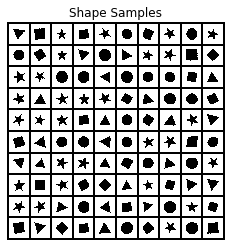

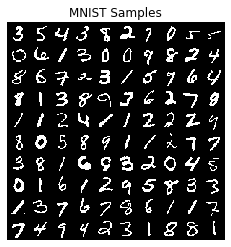

In [6]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [7]:
from exp_utils import *
import math

class MaskedLinear(nn.Linear):
    def __init__(self, in_feat, out_feat, px_dim, prev_mk):
        super(MaskedLinear, self).__init__(in_feat, out_feat, bias=True)
        self.mask = nn.Parameter(torch.zeros(out_feat, in_feat), requires_grad=False)
#         self.mask = torch.zeros(out_feat, in_feat)
        prev_min = prev_mk.min().int()
        self.mk = torch.randint(prev_min, px_dim, (out_feat,))
        for outidx in range(out_feat):
            for inidx in range(in_feat):
                if self.mk[outidx] >= prev_mk[inidx]:
                    self.mask[outidx, inidx] = 1.
                
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)


class MaskedLinearOut(nn.Linear):
    def __init__(self, in_feat, out_feat, px_dim, prev_mk):
        super(MaskedLinearOut, self).__init__(in_feat, out_feat, bias=True)
        self.mask = nn.Parameter(torch.zeros(out_feat, in_feat), requires_grad=False)
#         self.mask = torch.zeros(out_feat, in_feat)
        self.mk = (torch.arange(px_dim)+1)
        for outidx in range(out_feat):
            for inidx in range(in_feat):
                if self.mk[outidx] > prev_mk[inidx]:
                    self.mask[outidx, inidx] = 1.
                
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

class Made(nn.Module):
    def __init__(self, image_shape, hidden=[512, 512, 512]):
        super(Made, self).__init__()
        self.image_shape = image_shape
        self.px_dim = math.prod(image_shape)
        layers = []
        dims = [self.px_dim] + hidden
        prev_mk = (torch.arange(self.px_dim)+1)
        for idx in range(len(dims)-1):
            layers.append(MaskedLinear(dims[idx], dims[idx+1], self.px_dim, prev_mk))
            prev_mk = layers[-1].mk
            layers.append(nn.ReLU())
        layers.append(MaskedLinearOut(dims[-1], dims[0], self.px_dim, prev_mk))
        self.sequential = nn.Sequential(*layers)
        self.loss_func = nn.BCEWithLogitsLoss(reduction='none')
        
    def forward(self, x):
        logits = self.sequential(x.float())
        return logits
        
    def loss_function(self, preds, targets):
        loss = self.loss_func(preds, targets.float()).sum(dim=1).mean(dim=0)
        return loss
    
    def sampling(self, size):
        print('begin sampling')
        self.eval()
        with torch.no_grad():
            sample = torch.ones(size, self.px_dim)
            if next(self.parameters()).is_cuda:
                sample = sample.cuda()
            for i in range(self.px_dim):
                logits = self.forward(sample)
                sample[:,i] = torch.bernoulli(torch.sigmoid(logits[:,i]))
            images = sample.view(-1, self.image_shape[0], self.image_shape[1], 1)
        return images
                

In [8]:
import math
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    """ YOUR CODE HERE """
    train_data = np.reshape(train_data, (-1, math.prod(image_shape)))
    test_data = np.reshape(test_data, (-1, math.prod(image_shape)))

    
    DEVICE = torch.device('cuda')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=128)
    model = Made((image_shape), [512, 512]).to(DEVICE)
    adam_optim = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        model, adam_optim, learn_rate=0.001, device=DEVICE, epochs=20)
#     breakpoint()
    return nll_train, nll_test, model.sampling(100).cpu().numpy()

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Epoch 0 loss train: 73.99867248535156, test: 74.446533203125
Epoch 1 loss train: 60.45716857910156, test: 59.628658294677734
Epoch 2 loss train: 52.36808776855469, test: 51.65623092651367
Epoch 3 loss train: 48.01506042480469, test: 47.34516143798828
Epoch 4 loss train: 40.8814582824707, test: 43.67152404785156
Epoch 5 loss train: 42.736087799072266, test: 40.85203552246094
Epoch 6 loss train: 38.57990264892578, test: 38.80786895751953
Epoch 7 loss train: 35.619319915771484, test: 37.04262924194336
Epoch 8 loss train: 33.63517379760742, test: 35.06816482543945
Epoch 9 loss train: 34.384342193603516, test: 33.43761444091797
Epoch 10 loss train: 29.797271728515625, test: 32.19630813598633
Epoch 11 loss train: 31.660486221313477, test: 31.194719314575195
Epoch 12 loss train: 30.346820831298828, test: 30.314455032348633
Epoch 13 loss train: 28.39349365234375, test: 29.663043975830078
Epoch 14 loss train: 27.76577377319336, test: 28.780120849609375
Epoch 15 loss train: 28.646087646484375, t

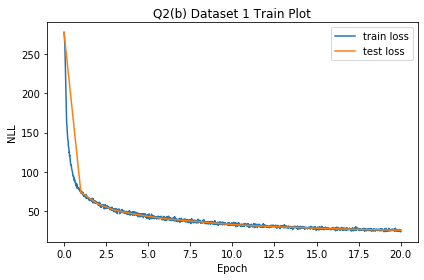

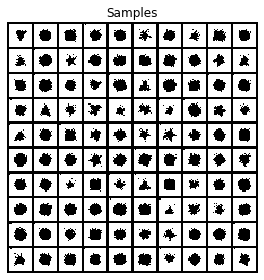

In [9]:
q2_save_results(1, 'b', q2_b)

Epoch 0 loss train: 160.69046020507812, test: 155.89859008789062
Epoch 1 loss train: 128.83352661132812, test: 126.07485961914062
Epoch 2 loss train: 111.73081970214844, test: 111.9501953125
Epoch 3 loss train: 108.86236572265625, test: 104.91542053222656
Epoch 4 loss train: 101.71345520019531, test: 100.52861785888672
Epoch 5 loss train: 103.49568939208984, test: 97.59365844726562
Epoch 6 loss train: 97.93211364746094, test: 95.48503875732422
Epoch 7 loss train: 102.44187927246094, test: 93.90746307373047
Epoch 8 loss train: 88.89994812011719, test: 92.83601379394531
Epoch 9 loss train: 96.46305847167969, test: 91.93867492675781
Epoch 10 loss train: 91.0279541015625, test: 91.14454650878906
Epoch 11 loss train: 92.2295150756836, test: 90.48819732666016
Epoch 12 loss train: 87.2453842163086, test: 89.58407592773438
Epoch 13 loss train: 83.58084106445312, test: 89.27989196777344
Epoch 14 loss train: 89.19221496582031, test: 88.62007141113281
Epoch 15 loss train: 91.56443786621094, test:

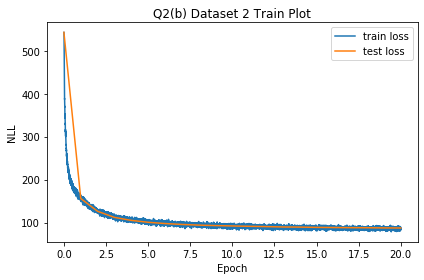

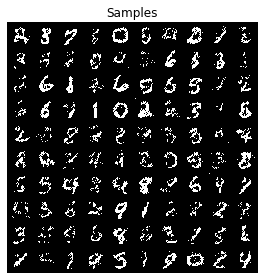

In [10]:
q2_save_results(2, 'b', q2_b)